In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, SVG, HTML
import pandas as pd
import altair as alt
import re
import pickle
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results, BenchmarkType, SchedulerType, get_broadcast_source, get_async_source
from benchmarks.utils import echo
from benchmarks.throughput import make_benchmark, make_multiple_message_benchmark

In [2]:
#benchmark_results = get_benchmark_results()
from benchmark_result import BenchmarkResult, Result 
with open('saved_results.pkl', 'rb') as saved_results:
    benchmark_results = pickle.load(saved_results)

## ipyparallel benchmark results ##

### time_broadcast

This benchmark comes from benchmaring the runtime of sending and returning different size arrays to different number of engines with the echo function on various scheduler implementations


In [12]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x, **kwargs):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/utils.py
Type:      function


In [13]:
??make_benchmark

Signature: make_benchmark(benchmark_name, get_view)
Docstring: <no docstring>
Source:   
def make_benchmark(benchmark_name, get_view):
    class ThroughputSuite:
        param_names = ['delay', 'Number of engines', 'Number of bytes']
        timer = timeit.default_timer
        timeout = 60
        params = [delay, engines, byte_param]

        view = None
        client = None
        reply = None

        def setup(self, delay, number_of_engines, number_of_bytes):
            self.client = ipp.Client(profile='asv', cluster_id='depth_3')
            self.view = get_view(self)
            self.view.targets = list(range(number_of_engines))
            wait_for(lambda: len(self.client) >= number_of_engines)

        def time_broadcast(self, delay, engines, number_of_bytes):
            self.reply = self.view.apply_sync(
                echo(delay),
                np.array([0] * number_of_bytes, dtype=np.int8),
            )

        def teardown(self, *args):
            replies_key = t

### Results from running benchmark on 64 cores


In [19]:
source = get_broadcast_source(benchmark_results)[64]

In [20]:
dview = []
for delay, results_for_delay in source.items():
    data = pd.DataFrame(results_for_delay['DirectView']) 
    data['Delay'] = delay
    data['Scheduler name'] = 'DirectView'
    data['Speedup'] = 1
    dview.append(data)
dview = pd.concat(dview)

In [21]:
source
datas = []
for delay, results_for_delay in source.items():
    for scheduler_name, scheduler_results in results_for_delay.items():
        data = pd.DataFrame(scheduler_results) 
        data['Delay'] = delay
        data['Scheduler name'] = scheduler_name
        data['Speedup'] = dview[dview['Delay'] == delay]['Duration in ms'] / data['Duration in ms']
        datas.append(data)
data = pd.concat(datas)
data

,Duration in ms,Number of bytes,Number of engines,Delay,Scheduler name,Speedup
0,8.69,1000.0,2.0,0.0,Coalescing,0.555811
1,9.68,10000.0,2.0,0.0,Coalescing,0.579545
2,16.97,100000.0,2.0,0.0,Coalescing,0.744255
3,88.53,1000000.0,2.0,0.0,Coalescing,0.914492
4,167.21,2000000.0,2.0,0.0,Coalescing,0.934633
...,...,...,...,...,...,...
20,161.04,1000.0,256.0,0.0,NonCoalescing,0.992859
21,160.58,10000.0,256.0,0.0,NonCoalescing,1.028522
22,174.59,100000.0,256.0,0.0,NonCoalescing,1.143708
23,337.24,1000000.0,256.0,0.0,NonCoalescing,2.378069


### With a delay of 0.0

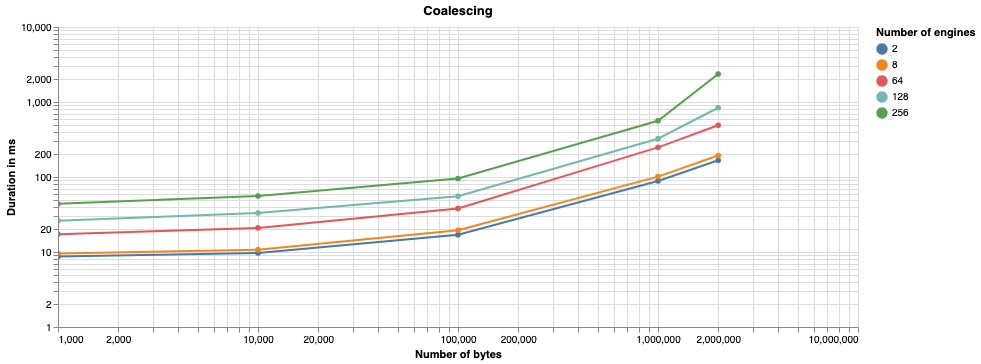

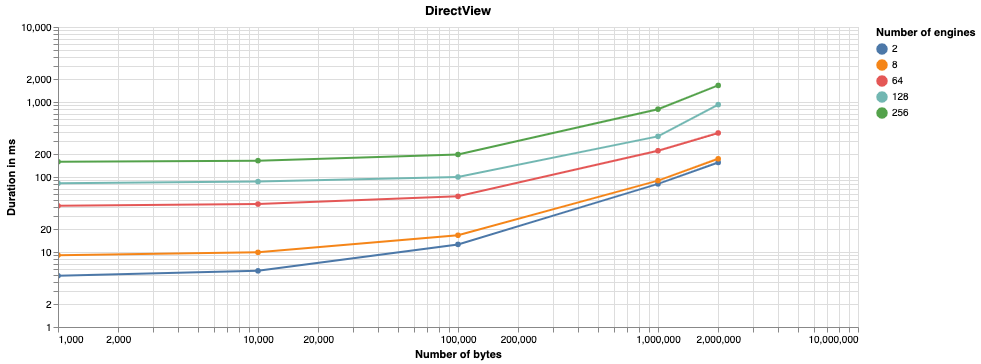

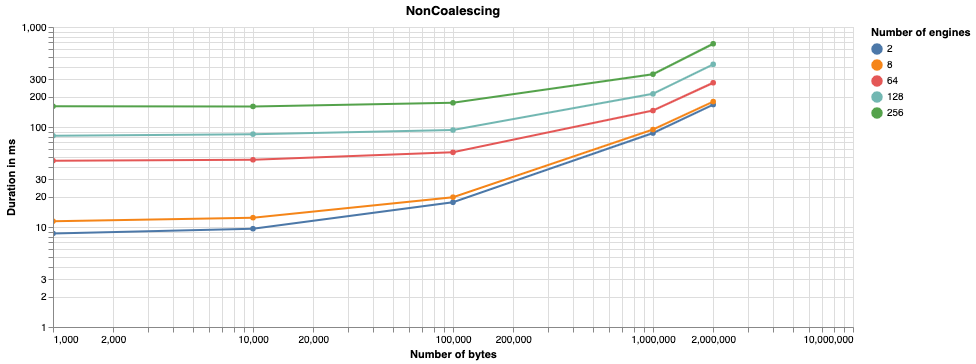

In [22]:
for delay in data['Delay'].unique():    
    display(Markdown(f'### With a delay of {delay}'))
    for scheduler_name in data[data['Delay'] == delay]['Scheduler name'].unique():
        scheduler_data = data[(data['Delay'] == delay) & (data['Scheduler name'] == scheduler_name)]
        alt.Chart(scheduler_data).mark_line(point=True).encode(
            alt.X(
                'Number of bytes',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'Duration in ms',
                scale=alt.Scale(type='log')

            ),
            color='Number of engines:N',
            tooltip='Duration in ms',
    
        ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')


## Results for duration[DirectView]/duration[scheduler]

### With a delay of 0.0

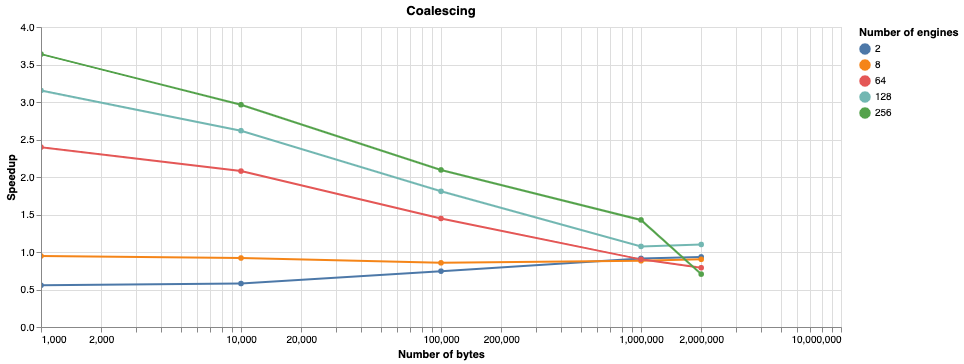

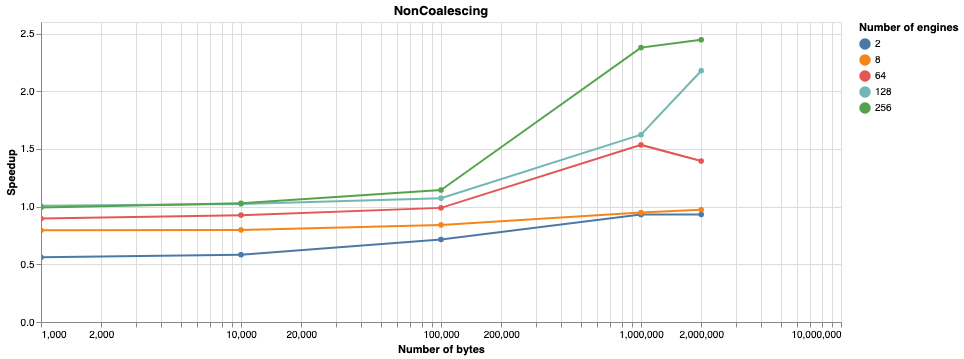

In [23]:
display(Markdown(f'## Results for duration[DirectView]/duration[scheduler]'))
for delay in data['Delay'].unique():    
    display(Markdown(f'### With a delay of {delay}'))
    for scheduler_name in data[data['Delay'] == delay]['Scheduler name'].unique():
        if scheduler_name == 'DirectView':
            continue
        alt.Chart(data[(data['Delay'] == delay) & (data['Scheduler name'] == scheduler_name)]).mark_line(point=True).encode(
            alt.X(
                'Number of bytes',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'Speedup',
            ),
            color='Number of engines:N',
            tooltip='Duration in ms',
    
        ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')

## With 0.0 delay:

### Running on 2.0 engines

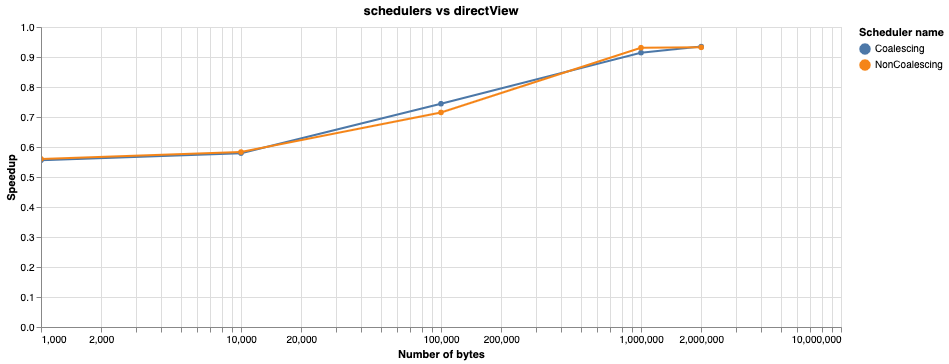

### Running on 8.0 engines

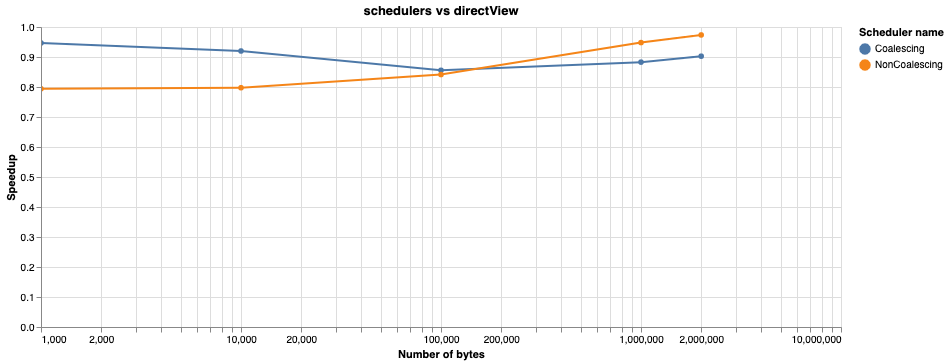

### Running on 64.0 engines

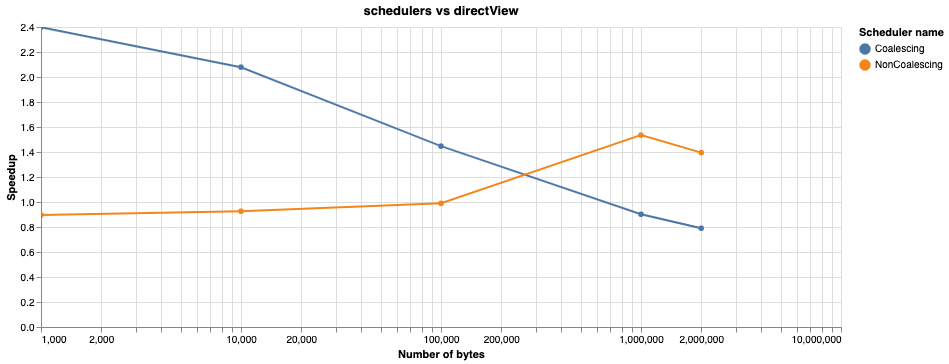

### Running on 128.0 engines

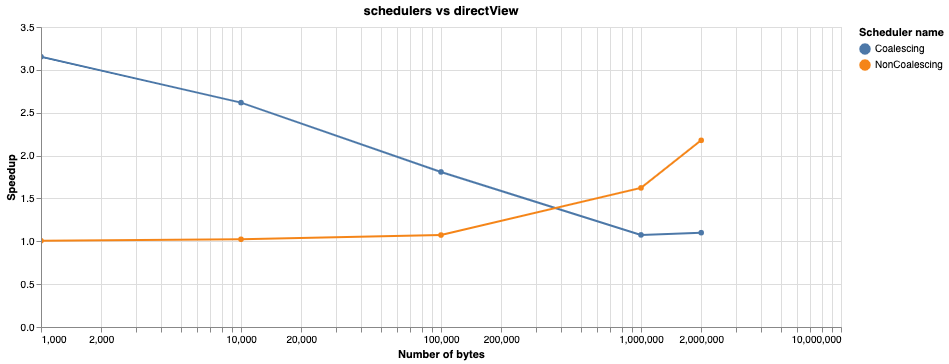

### Running on 256.0 engines

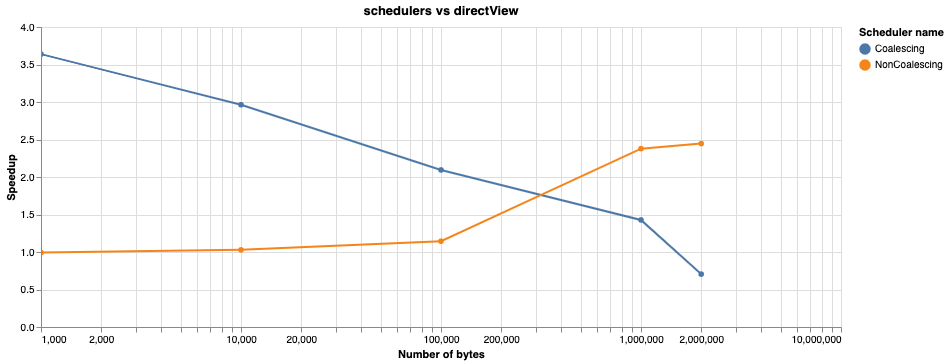

In [19]:

for delay in data['Delay'].unique():
    display(Markdown(f'## With {delay} delay:'))
    for engine in data['Number of engines'].unique():
        display(Markdown(f'### Running on {engine} engines'))
        alt.Chart(data[(data['Delay'] == delay) & (data['Number of engines'] == engine) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='Scheduler name:N',
        tooltip='Duration in ms',
    ).properties(title='schedulers vs directView', width=800).interactive().display(renderer='svg')

## With 0.0 delay:

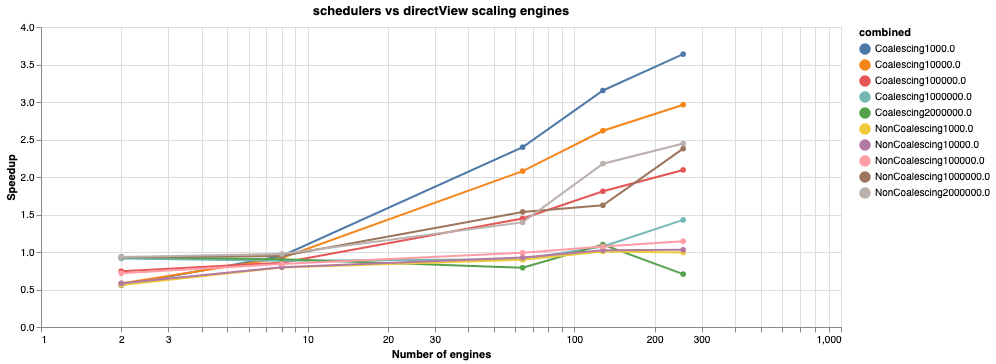

In [20]:
data['combined']=  data['Scheduler name'] + data['Number of bytes'].astype(str)

for delay in data['Delay'].unique():
    display(Markdown(f'## With {delay} delay:'))
    alt.Chart(data[(data['Delay'] == delay) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of engines',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='combined:N',
        tooltip='combined',
    ).properties(title='schedulers vs directView scaling engines', width=800).interactive().display(renderer='svg')


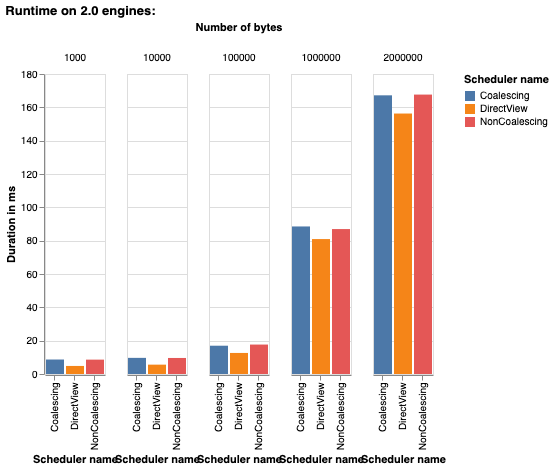

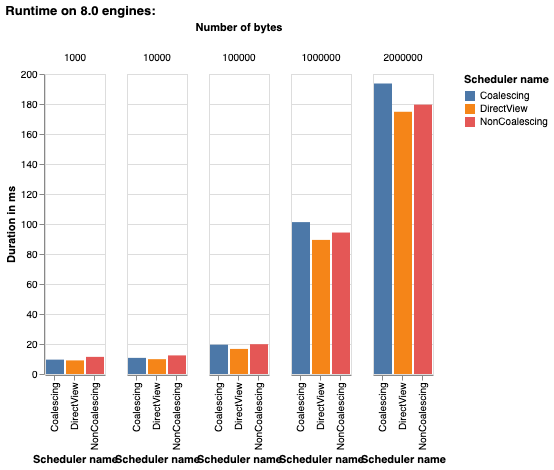

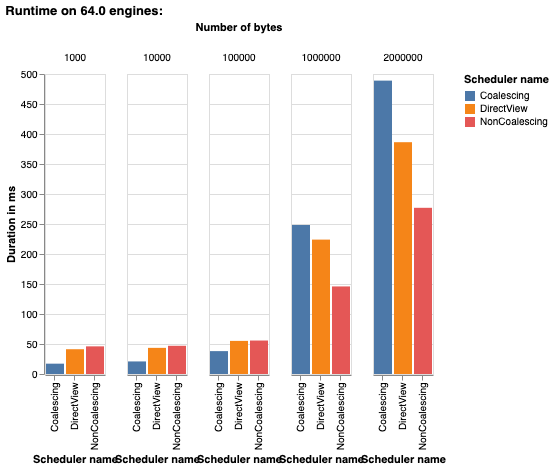

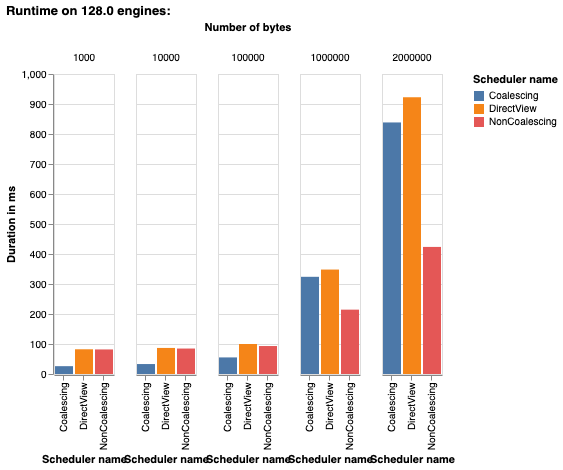

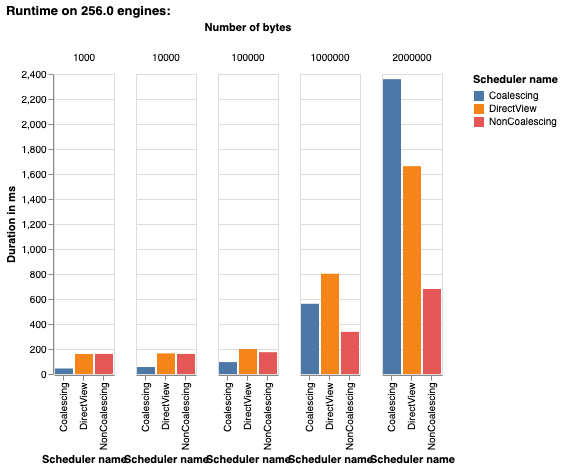

In [24]:
for engine in data['Number of engines'].unique():    
    alt.Chart(data[(data['Delay'] == 0) & (data['Number of engines'] == engine)]).mark_bar().encode(
        x='Scheduler name',
        y='Duration in ms',
        color='Scheduler name:N',
        column='Number of bytes:N',    
        tooltip='Duration in ms'
    ).properties(title=f'Runtime on {engine} engines:').interactive().display(renderer='svg')

## time_async_messages

In [25]:
??make_multiple_message_benchmark

Signature: make_multiple_message_benchmark(get_view)
Docstring: <no docstring>
Source:   
def make_multiple_message_benchmark(get_view):
    class AsyncMessagesSuite:
        param_names = ['Number of engines', 'number_of_messages']
        timer = timeit.default_timer
        timeout = 60
        params = [engines, [1, 10, 100]]

        view = None
        client = None
        reply = None

        def setup(self, number_of_engines, number_of_messages):
            self.client = ipp.Client(profile='asv', cluster_id=f'depth_3')
            self.view = get_view(self)
            self.view.targets = list(range(number_of_engines))

            wait_for(lambda: len(self.client) >= number_of_engines)

        def time_async_messages(
            self, number_of_engines, number_of_messages
        ):
            replies = []
            for i in range(number_of_messages):
                reply = self.view.apply_async(
                    echo(0),
                    np.array([0] * 1000, dt

In [25]:
source = get_async_source(benchmark_results)[64]

In [26]:
dview = pd.DataFrame(source['DirectView']) 
dview['Scheduler name'] = 'DirectView'
dview['Speedup'] = 1
dview

,Duration in ms,Number of messages,Number of engines,Scheduler name,Speedup
0,5.16,1,2,DirectView,1
1,32.94,10,2,DirectView,1
2,280.30,100,2,DirectView,1
3,9.23,1,8,DirectView,1
4,53.18,10,8,DirectView,1
5,528.69,100,8,DirectView,1
6,42.97,1,64,DirectView,1
7,412.16,10,64,DirectView,1
8,3941.81,100,64,DirectView,1
9,84.56,1,128,DirectView,1


In [27]:
datas = []
for scheduler_name, scheduler_results in source.items():
    data = pd.DataFrame(scheduler_results) 
    data['Scheduler name'] = scheduler_name
    data['Speedup'] = 1 if scheduler_name == 'DirectView' else dview['Duration in ms'] / data['Duration in ms']
    datas.append(data)
data = pd.concat(datas)
data

,Duration in ms,Number of messages,Number of engines,Scheduler name,Speedup
0,8.62,1,2,Coalescing,0.598608
1,33.80,10,2,Coalescing,0.974556
2,297.74,100,2,Coalescing,0.941425
3,10.17,1,8,Coalescing,0.907571
4,43.36,10,8,Coalescing,1.226476
5,357.11,100,8,Coalescing,1.480468
6,16.89,1,64,Coalescing,2.544109
7,77.53,10,64,Coalescing,5.316136
8,669.19,100,64,Coalescing,5.890420
9,26.97,1,128,Coalescing,3.135336


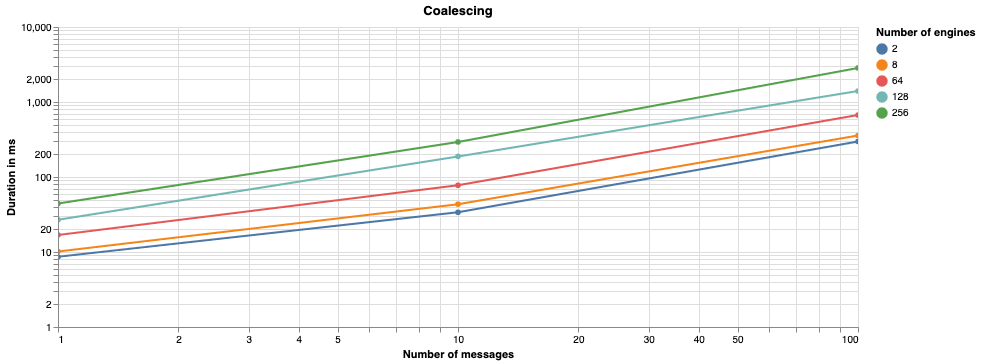

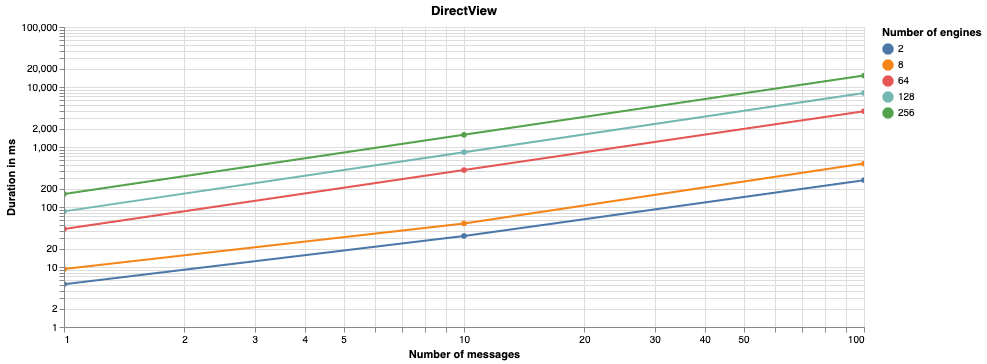

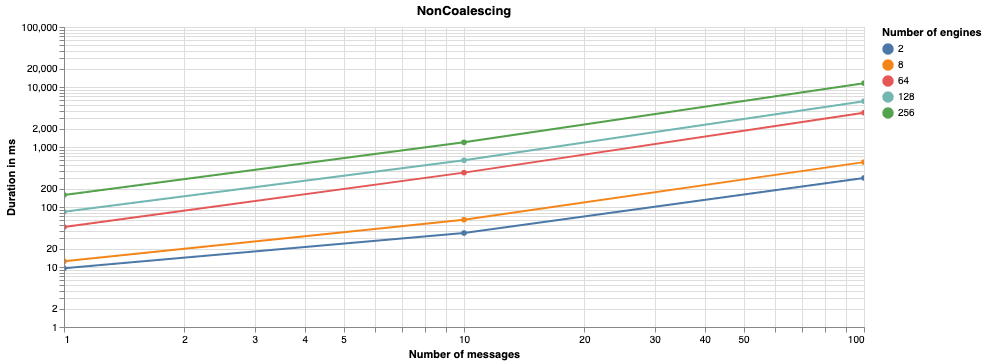

In [28]:
for scheduler_name in data['Scheduler name'].unique():
    scheduler_data = data[data['Scheduler name'] == scheduler_name]
    alt.Chart(scheduler_data).mark_line(point=True).encode(
        alt.X(
            'Number of messages',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Duration in ms',
            scale=alt.Scale(type='log')
        ),
        color='Number of engines:N',
        tooltip='Duration in ms',
    
    ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')

### Running on 2 engines

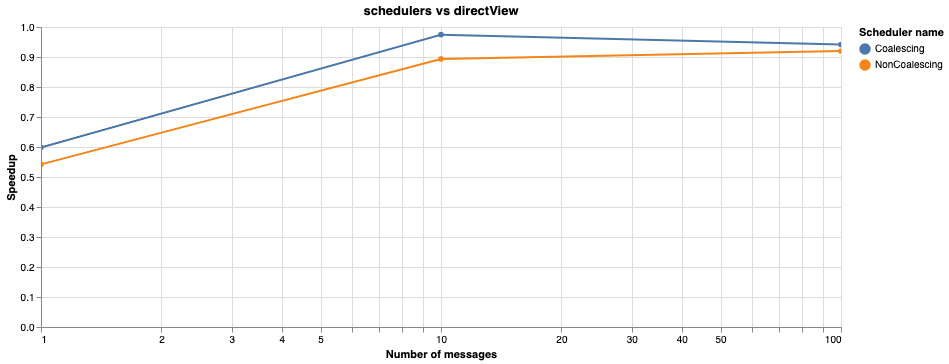

### Running on 8 engines

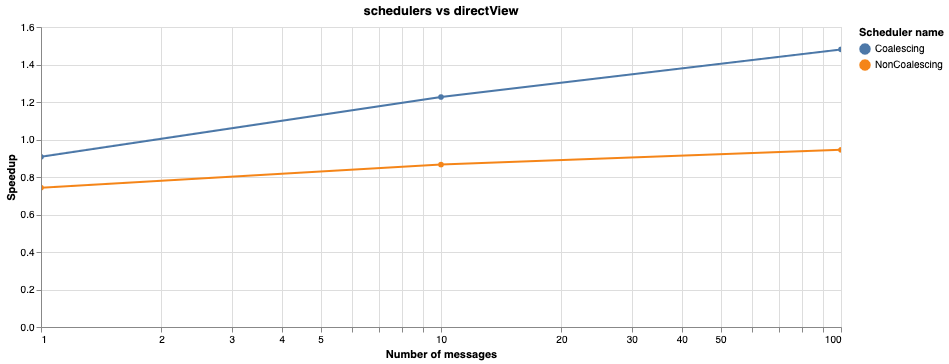

### Running on 64 engines

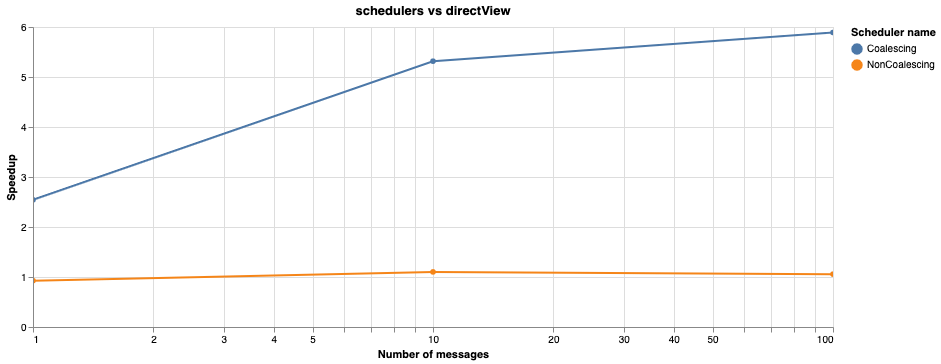

### Running on 128 engines

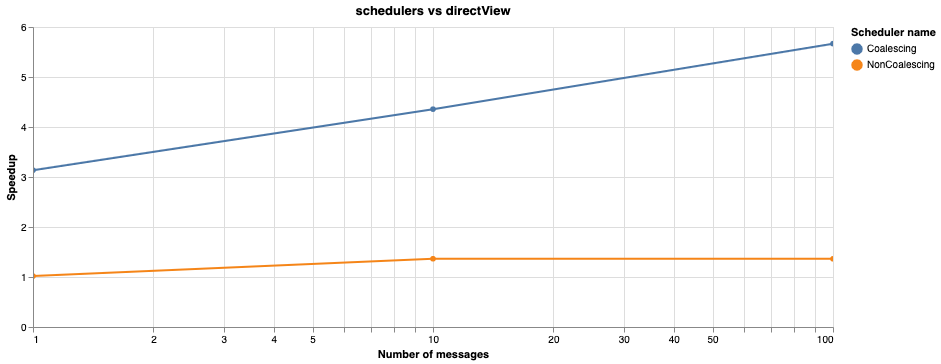

### Running on 256 engines

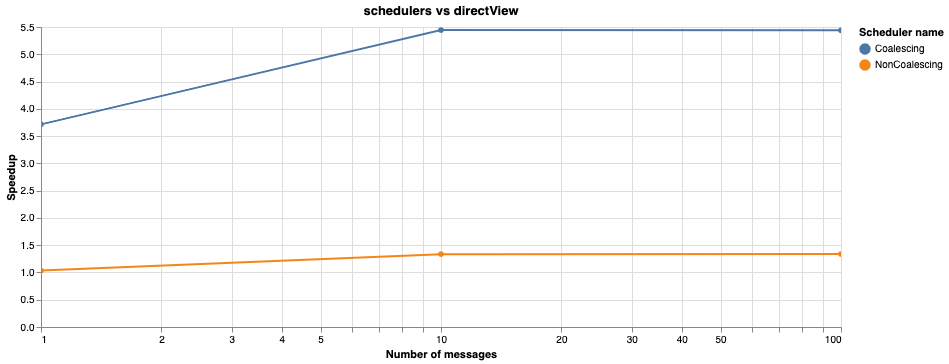

In [30]:
for engine in data['Number of engines'].unique():
    display(Markdown(f'### Running on {engine} engines'))
    alt.Chart(data[(data['Number of engines'] == engine) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of messages',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='Scheduler name:N',
        tooltip='Duration in ms',
    ).properties(title='schedulers vs directView', width=800).interactive().display(renderer='svg')

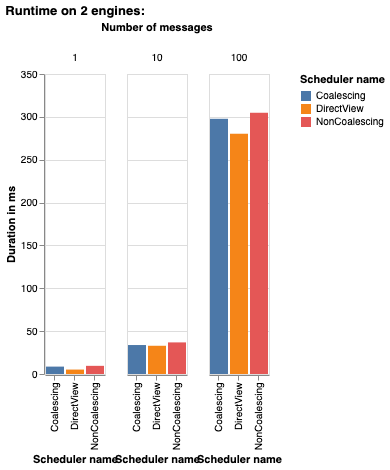

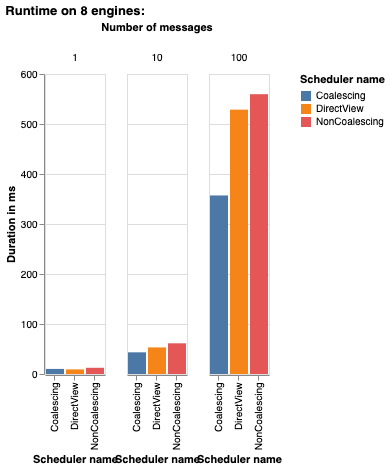

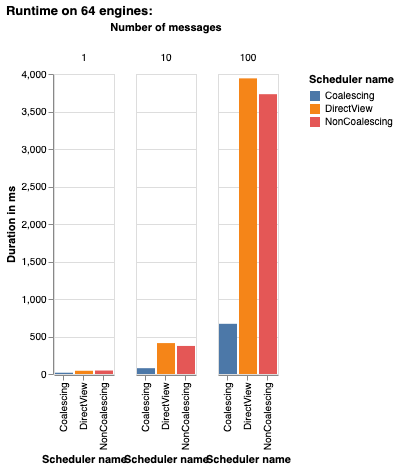

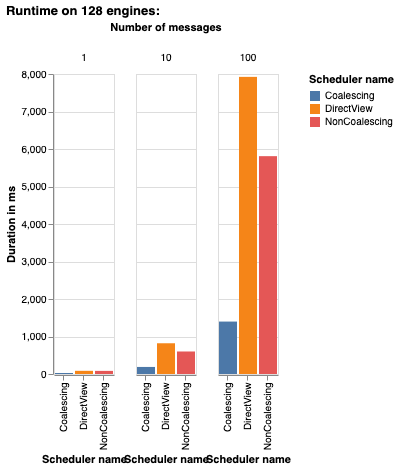

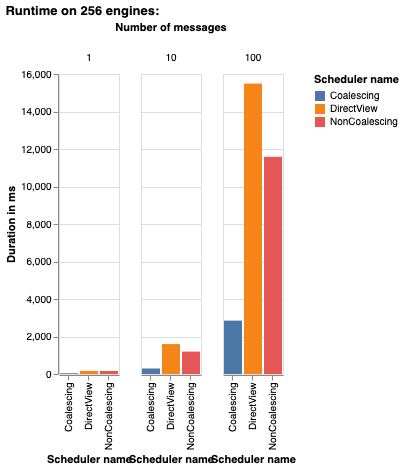

In [32]:
for engine in data['Number of engines'].unique():    
    alt.Chart(data[data['Number of engines'] == engine]).mark_bar().encode(
        x='Scheduler name',
        y='Duration in ms',
        color='Scheduler name:N',
        column='Number of messages:N',    
        tooltip='Duration in ms'
    ).properties(title=f'Runtime on {engine} engines:').interactive().display(renderer='svg')